# Quiz

Name: Ali Furkan Kalay

ID: 45625365

Question 3: *Describe how we should modify the simulation code to obtain a simulated path of consumption.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Stochastic problems

The above methods can be applied to a stochastic setting.

Suppose that $z$ is a Markov process.


$$ \max_{\{x_t\}} \mathbb{E}\left[ \sum_{t=0}^\infty \beta^t r(x_t,x_{t+1},z_t)\quad  |z_0 \right]$$

subject to 

$$ x_{t+1} \in F(x_t,z_t), \forall t\ge0,$$

and 

$$ x_0 = \overline{x}_0.$$

Its recursive formulation is:

$$ v(x,z) = \max_{x'} \{ r(x,x',z) + \beta \mathbb{E}[v(x',z')|z] \}$$

subject to 

$$ x' \in F(x,z).$$


An example is the stochasic Ramsey model:

$$ \max_{\{x_t\}} \mathbb{E}\left[\sum_{t=0}^\infty \beta u( f(k_t,A_t) + (1-\delta)k_t -g_t - k_{t+1})\quad |A_0,g_0\right] $$

subject to 

$$ 0\le k_{t+1} \le f(k_t,A_t) + (1-\delta)k_t -g_t, $$

and 

$$ k_0 = \overline{k}_0.$$

Here $(g_t,A_t)$ are Makrovian stochastic processes.


For example, $(g_t,A_t)$ may follow a Markov chain, or may follow AR(1) processes:

\begin{eqnarray*}
\ln g_t &=& (1-\rho^g)\ln \overline{g} + \rho^g \ln g_{t-1} +\epsilon^g_t,\\
\ln A_t &=& (1-\rho^A)\ln \overline{A} + \rho^A \ln A_{t-1} +\epsilon^A_t\\
\end{eqnarray*}

with $(\epsilon^g_t,\epsilon^A_t)$ being IID over time. 

### Discretization

Let us generalize the discretization code to incorporate a stochasitc shock.

In the above numerical example, $g=0$ always. Here we consider the following specification:

$$ g \in \{g^L, g^H\},$$

with $g^H=0.15(1+\epsilon)$, $g^L = 0.15(1-\epsilon)$, and $\epsilon = 0.1$. The spending shock is persistent and 

$ p_{HH} = p_{LL} = 0.8$ and $p_{HL}=p_{LH}=0.2$, where $p_{ij}$ is the probability of switching from $g^i$ to $g^j$.

Our goal is to characterize the value function and the policy function.

Note that if $k$ is too low, even $g_L$ may be bigger than the total output. To make sure that the constraint set is non-empty, we need to increase $k_{min}$.

Again it is convenient to define the function $r(i,j,s)$ that equals the current utility when the current period capital is $k^i$, the next period capital is $k^j$, and the exogenous state is $s$ (i.e. $g= g^s$ with $s \in \{L,H\}$). 

\begin{eqnarray}
 r(i,j,s) &=& \left\{\begin{array}{ll}
                 u( f(k^i) + (1-\delta)k^i -g^s - k^j) & \mbox{ if $f(k^i) + (1-\delta)k^i -g^s - k^j \ge 0$,}\\
                 -\infty & \mbox{ otherwise}.
                 \end{array}\right.
\end{eqnarray}


In [2]:
# VFI (Discretization)

# parameters
bbeta = 0.99
aalpha = 0.3
ddelta = 0.1
ssigma = 1.00001
tfp = (1/bbeta-1+ddelta)/aalpha
gss = 0.15

n_st = 2 # number of states
g_eps = 0.1
gvec = [gss*(1-g_eps), gss*(1+g_eps)]
Pr_mat = np.array([[0.8, 0.2],
                    [0.2, 0.8]])

util = lambda c: (c**(1-ssigma)-1.)/(1.-ssigma)
const_c = lambda k,kp,g: tfp*k**aalpha+(1.-ddelta)*k-kp-g 

n_kgrid = 1000
kmin = 0.5
kmax = 1.8
kgrid = np.linspace(kmin,kmax,n_kgrid)

r_mat = np.zeros((n_kgrid, n_kgrid, n_st))

ctol = 1.0e-8

for i in range(n_kgrid):
    for j in range(n_kgrid):
        for i_st in range(n_st):
            c = const_c(kgrid[i],kgrid[j],gvec[i_st])
            if c>ctol:
                r_mat[i,j,i_st] = util(c)
            else:
                r_mat[i,j,i_st] = -np.inf

V0 = np.zeros((n_kgrid,n_st))
V1 = np.zeros((n_kgrid,n_st))
kp_opt = np.zeros((n_kgrid,n_st),'int')
column1 = np.ones((n_kgrid,1))

i_iter = 1
max_iter = 10000

vdiff = 1.0
vtol = 1.0e-7

while i_iter<=max_iter:
    for i_st in range(n_st):
        obj_mat = r_mat[:,:,i_st] + bbeta*column1@(np.reshape(Pr_mat[i_st,:]@V0.T,(1,n_kgrid)))
            # What is the (i,j)-element of obj_mat?
            
        kp_opt[:,i_st] = np.argmax(obj_mat,1)
        V1[:,i_st] = np.amax(obj_mat,1)

    vdiff = np.linalg.norm(V0-V1)

    #print(i_iter, vdiff)

    if vdiff<vtol:
        break

    V0[:,:] = V1[:,:]
    i_iter += 1

# policy function


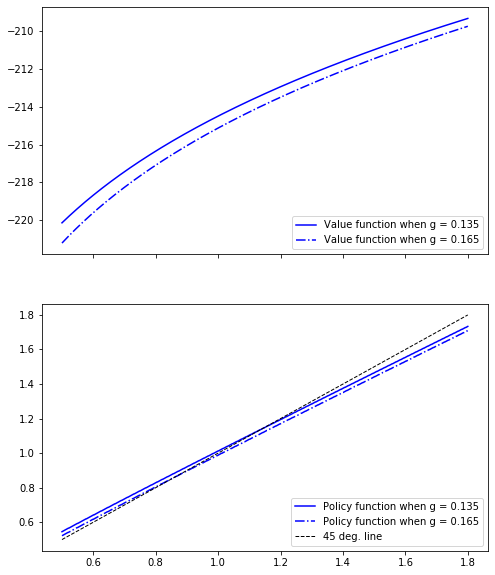

In [3]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(8,10))
ax1.plot(kgrid, V1[:,0], 'b-', label='Value function when g = '+str(gvec[0]))
ax1.plot(kgrid, V1[:,1], 'b-.', label='Value function when g = '+str(gvec[1]))
ax1.legend(loc='lower right')

ax2.plot(kgrid, kgrid[kp_opt[:,0]], 'b-', label='Policy function when g = '+str(gvec[0]))
ax2.plot(kgrid, kgrid[kp_opt[:,1]], 'b-.', label='Policy function when g = '+str(gvec[1]))
ax2.plot(kgrid, kgrid, 'k--', linewidth = 1.0, label='45 deg. line')
ax2.legend(loc='lower right')
plt.show()

### Simulating the solution

Once we obtain the policy function, we can use it to simulate an equilibrium path.

The idea here is that the policy function together with the Markov transition probability determines a transition from the current state $(k,z)$ the next period capital $(k',z')$. $z'$ is drawn from its conditional distribution given $z$, and $k'$ is pinned down by the policy function.

The policy function above is defined only on a finite grid. Here we use it as it is, so in any period $k$ is on the grid. However, you may interpolate the policy function over the whole interval $[k_{min},k_{max}]$. 


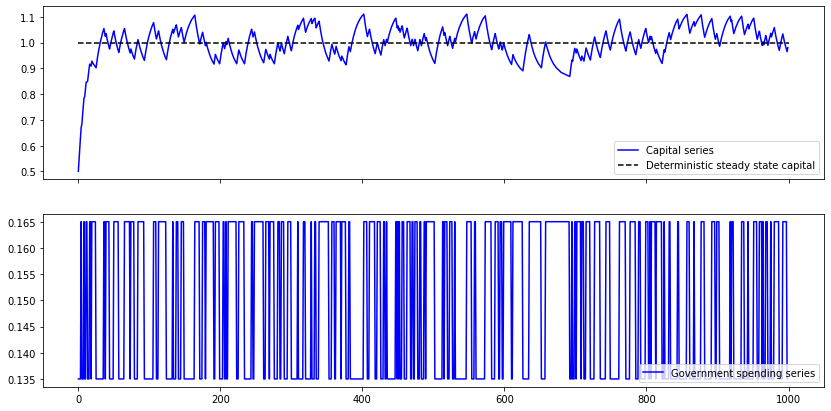

In [4]:
np.random.seed(100)

Tsim = 1000

k_simul = np.zeros(Tsim)
g_simul = np.zeros(Tsim)

ki0 = 0 # initial capital index. k0 = kgrid[ki0]
gj0 = 0 # initial shock index. g0 = gvec[gj0]

k_simul[0] = kgrid[ki0]
g_simul[0] = gvec[gj0]

for t in range(Tsim-1):
    ki1 = kp_opt[ki0,gj0]
    if np.random.rand() <= Pr_mat[gj0,0]:
        gj1 = 0
    else:
        gj1 = 1
    k_simul[t+1], g_simul[t+1] = kgrid[ki1], gvec[gj1] 
    ki0, gj0 = ki1, gj1 
    
    
fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(14,7))
ax1.plot(k_simul, 'b-', label='Capital series')
ax1.plot([0,Tsim], [1.0, 1.0], 'k--',label='Deterministic steady state capital')
ax1.legend(loc='lower right')

ax2.plot(g_simul, 'b-', label='Government spending series')
ax2.legend(loc='lower right')


plt.show()

## How to simulate the consumption path?

$$ c_t = tfp \times k_t^a + (1-\delta )k_t - k_{t+1} - g_t $$

In [5]:
consumption = lambda k,kp,g: tfp*k**aalpha+(1.-ddelta)*k-kp-g 
c_simul = np.zeros(len(k_simul))
for i in range(len(k_simul)-1):
    c_simul[i] = consumption(k_simul[i], k_simul[i+1], g_simul[i])

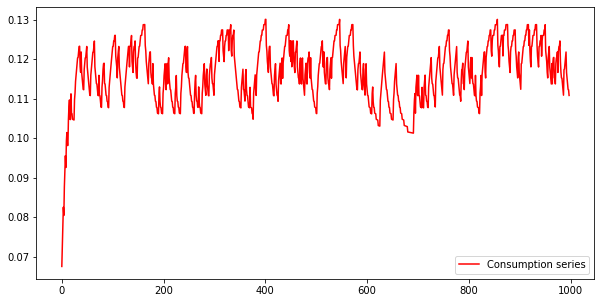

In [6]:
plt.figure(figsize=(10,5))
#plt.plot(k_simul[:-2], 'b-', label='Capital series')
plt.plot(c_simul[:-2], 'r-', label='Consumption series')
#plt.plot([0,Tsim], [1.0, 1.0], 'k--',label='Deterministic steady state capital')
plt.legend(loc='lower right')
plt.show()